In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import scipy
import scipy.stats as scs
import sys
import os

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts/')))
from plotter import *
from util import *

##### Read Data

In [4]:
df = pd.read_csv("../data/AdSmartABdata.csv")
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [5]:
df.shape

(8077, 9)

In [6]:
df_temp = df.query("not (yes == 0 & no == 0)")
df_temp.shape
#We can see that only 1243 users responded to the questionaire, For classical AB testing we are performing, those users who didn't 
# respond are not relevant, so we drop those rows.

(1243, 9)

#### Selecting the appropraite columns

In [7]:
df_clean = df_temp[['auction_id', 'experiment', 'yes', 'no']]


In [8]:
df_clean['aware'] = 0
df_clean.loc[df_clean['yes'] == 1, 'aware'] = 1
df_clean.loc[df_clean['yes'] == 0, 'aware'] = 0
#We assign 1 for 'aware' column if the response was 'yes' else we assing '0'

In [9]:
df_clean.drop(columns=['yes', 'no'], inplace=True)
df_clean = df_clean.set_index('auction_id')
df_clean
#Setting index and merging 'yes' and 'no' into column 'aware'

,experiment,aware
auction_id,,
0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,0
008aafdf-deef-4482-8fec-d98e3da054da,exposed,1
00a1384a-5118-4d1b-925b-6cdada50318d,exposed,0
00b6fadb-10bd-49e3-a778-290da82f7a8d,control,1
00ebf4a8-060f-4b99-93ac-c62724399483,control,0
...,...,...
ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,1
ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,1
ffb79718-6f25-4896-b6b3-e58b80a6e147,control,0


##### Summarize Data 

In [10]:
df_summary = df_clean.pivot_table( index='experiment', aggfunc='sum')
df_summary['total'] = df_clean.pivot_table( index='experiment', aggfunc='count')
df_summary['rate'] = df_clean.pivot_table( index='experiment')
df_summary['not aware'] = df_summary['total'] - df_summary['aware']
df_summary = df_summary.reindex(['aware', 'not aware', 'total', 'rate'], axis=1)
df_summary

,aware,not aware,total,rate
experiment,,,,
control,264,322,586,0.450512
exposed,308,349,657,0.468798


In [13]:
exposed_rate = df_summary['rate']['exposed']
control_rate = df_summary['rate']['control']

In [14]:
exposed_aware = df_summary['aware']['exposed']
control_aware = df_summary['aware']['control']

In [15]:
exposed_total = df_summary['total']['exposed']
control_total = df_summary['total']['control']

In [19]:
diff = exposed_rate - control_rate
diff
#We can see that the difference between conversion rates of the test and control groups is 0.018285619295484168.
#Even if we can see that there is a difference, we have to perform hyppothesis testing to be confident 

0.018285619295484168

#### Probability Distribution

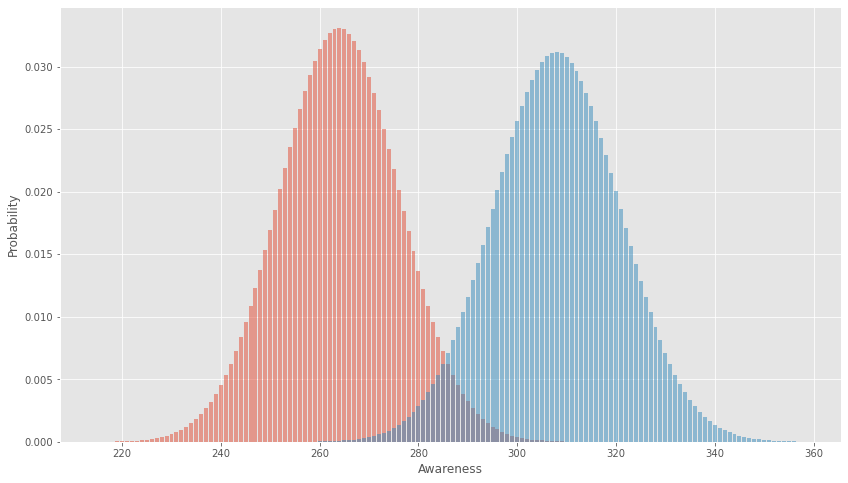

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))

xC = np.linspace(control_aware - 49, control_aware + 50, 100)
yC = scs.binom(control_total, control_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5, linestyle='--')
xE = np.linspace(exposed_aware - 49, exposed_aware + 50, 100)
yE = scs.binom(exposed_total , exposed_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5, linestyle='--')
plt.xlabel('Awareness')
plt.ylabel('Probability')
plt.show()
#The distribution on the right is the probability of conversions for the control group while the 
# distribution on the left is the probability of conversions for the exposed group.
#We can see there is a difference the mean of the two distributions.

#### Sample Mean Distribution

In [23]:
control_st_err = np.sqrt(control_rate * (1-control_rate)) / np.sqrt(control_total)
exposed_st_err = np.sqrt(exposed_rate * (1-exposed_rate)) / np.sqrt(exposed_total)
print(control_st_err)
print(exposed_st_err)
#Standard error of the mean

0.02055339057798332
0.019468837373132736


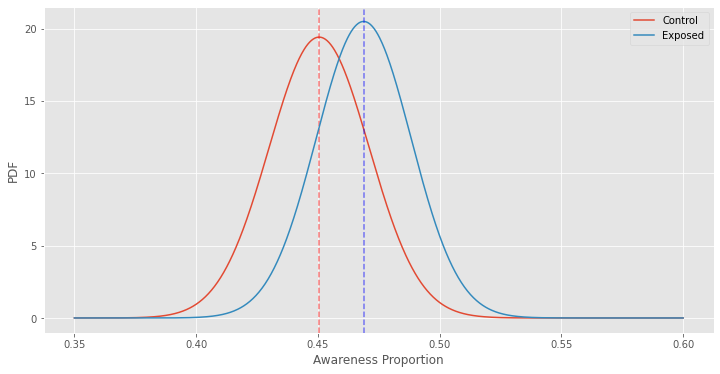

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(control_rate, control_st_err).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=control_rate, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exposed_rate, exposed_st_err).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=exposed_rate, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')
plt.show()
#The dashed lines represent the mean conversion rate for each group. 

#### Compare the Null Hypothesis vs. the Alternative Hypothesis

In [41]:
std_cont = np.sqrt(control_rate * (1 - control_rate) / control_total)
std_exp = np.sqrt(exposed_rate * (1 - exposed_rate) / exposed_total)
std_cont, std_exp

(0.02055339057798332, 0.019468837373132736)

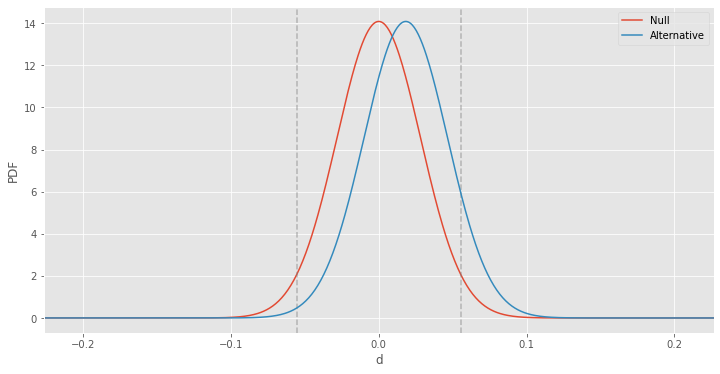

In [30]:
abplot(control_total, exposed_total, control_rate, diff)

### Statistical Power and Significance Level

#### Statistical Power

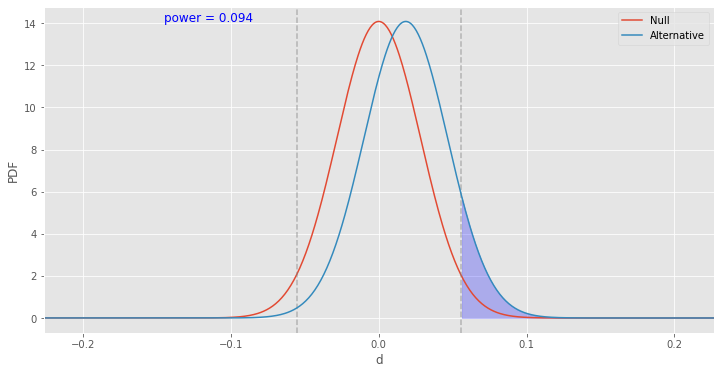

In [59]:
abplot(control_total, exposed_total, control_rate, diff, show_power=True)
#Statistical power is calculated by finding the area under the 
# alternative hypothesis distribution and outside of the confidence interval of the null hypothesis.
#Also Statistical power is the probability that the test correctly reject the null hypothesis.

#### beta

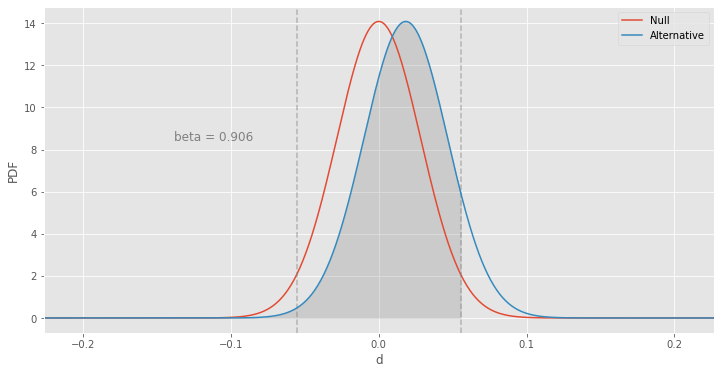

In [38]:
abplot(control_total, exposed_total, control_rate, diff, show_beta=True)
#The opposite area under the alternative curve is the probability that we accept the null hypothesis and 
# reject the alternative hypothesis (false negative). 
#This is referred to as beta in A/B testing or hypothesis testing and is shown below.

#### alpha

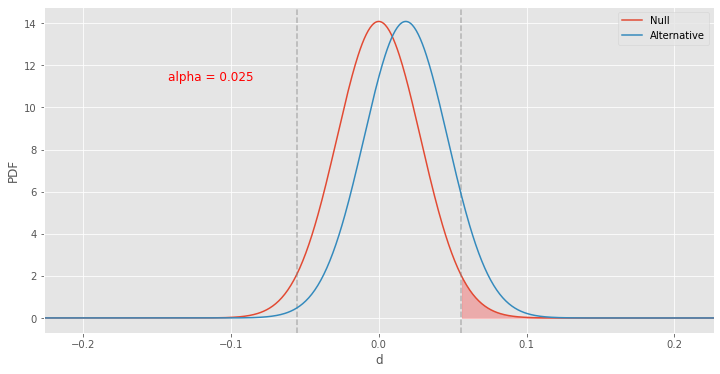

In [39]:
abplot(control_total, exposed_total, control_rate, diff, show_alpha=True)
#The gray dashed line that divides the area under the alternative curve into two 
# also directly segments the area associated with the significance level, often denoted with the greek letter alpha.


In [43]:
z_score = (diff) / np.sqrt(std_cont**2 + std_exp**2)
p_value = scs.norm().sf(z_score)
z_score, p_value
#We can see that the p-value is clearly considerably higher than the significance level, as can be shown.
# As a result, we cannot be certain of the lift's significance.

(0.6458981015684259, 0.2591726745827285)

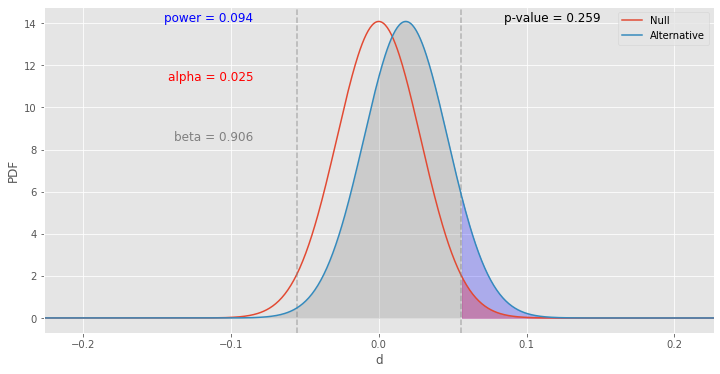

In [46]:
abplot(control_total, exposed_total, control_rate, diff, show_power=True, show_beta=True, show_alpha=True, show_p_value=True)
#As we can see the power is around 9.4%, which means there is a high chance of making type-II error.

#### Optimal Sample Size

In [67]:
power = 0.8
sig_level = 0.05
min_sample = round(min_sample_size(control_rate, diff, power,  sig_level))
print(f'{min_sample} is the minimum sample size to achieve 80% power.')

11661 is the minimum sample size to achieve 80% power.


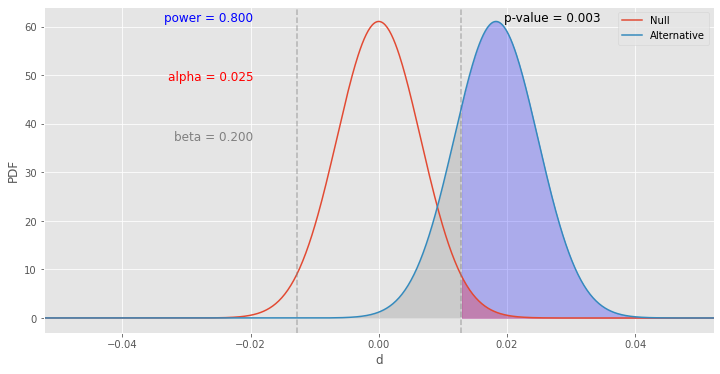

In [68]:
abplot(min_sample, min_sample, control_rate, diff, show_power=True, show_beta=True, show_alpha=True, show_p_value=True)